# 中值滤波

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import skimage.io as skio
import cv2
import pyopencl as cl

In [38]:
src = skio.imread('../../datas/f2.jpg')
rgba = cv2.cvtColor(src,cv2.COLOR_RGB2RGBA)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [39]:
#添加图像噪声
def salt(src,num):
    if type(src) == type(None):
        return None
    dst = src.copy()
    if len(src.shape) == 3 and src.shape[2] == 3:
        rows,cols,_ = src.shape
        for n in range(num):
            y = np.random.randint(rows - 1)
            x = np.random.randint(cols - 1)
            dst[y,x] = (255,255,255)
    elif len(src.shape) == 2:
        rows,cols = src.shape
        for n in range(num):
            y = np.random.randint(rows - 1)
            x = np.random.randint(cols - 1)
            dst[y,x] = 255
    else:
        return None
    
    return dst

In [52]:
def load_kernel_from_file(ctx,fname):
    sources = None
    kernel = None
    with open(fname,encoding='utf-8') as f:
        sources = str(f.read())
        kernel = cl.Program(ctx,sources).build()
    return kernel

def init_cl():
    # 创建Context
    # 如果有多个设备，则会提示选择
    ctx = cl.create_some_context()
    # 创建CommandQueue
    queue = cl.CommandQueue(ctx)
    return ctx,queue

def copy_image_to_device_readonly(ctx,src,imgformat):
    #imageFormat = cl.ImageFormat(cl.channel_order.RGBA,cl.channel_type.UNSIGNED_INT8)
    mf = cl.mem_flags
    img = cl.Image(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,imgformat,(src.shape[0],src.shape[1]),None,src.tobytes())
    return img

def create_device_write_only_image(ctx,imgformat,shape):
    mf = cl.mem_flags
    out = cl.Image(context=ctx,flags=mf.WRITE_ONLY,format=imgformat,shape=shape)
    return out

def copy_image_to_host(queue,output,size,dtype):
    buffer = np.zeros(size[0] * size[1] * 4,dtype=dtype)
    origin = ( 0, 0, 0 )
    region = (size[0] ,size[1], 1 ) 
    cl.enqueue_read_image(queue, output,
                        origin, region, buffer).wait()
    return buffer.reshape(size)

def copy_buffer_to_device_readonly(ctx,src):
    mf = cl.mem_flags
    src_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=src)
    return src_g

def create_device_buffer(ctx,src):
    mf = cl.mem_flags
    src_g = cl.Buffer(ctx, mf.WRITE_ONLY,src.nbytes)
    return src_g

def copy_buffer_to_host(queue,src_dev,shape,dtype):
    result = np.zeros(shape=shape,dtype=dtype)
    cl.enqueue_copy(queue, result, src_dev)
    return result

In [41]:
def cal_work_size(groupSize, globalSize):  
    r = globalSize % groupSize;  
    if r == 0:  
        return globalSize
    else:  
        return globalSize + groupSize - r

In [42]:
ctx,queue = init_cl()

In [43]:
kernel = load_kernel_from_file(ctx,'../../datas/cl/median_filter.cl')

In [44]:
noise = salt(gray,5000)
noise = np.float32(noise)

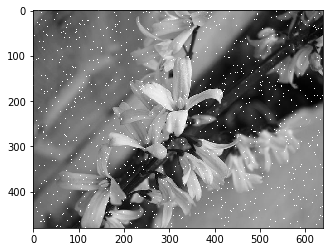

In [45]:
plt.imshow(noise,'gray')

In [46]:
noise_dev = copy_buffer_to_device_readonly(ctx,noise)
result_dev = create_device_buffer(ctx,noise)

In [47]:
rows,cols = np.int32(gray.shape[0]),np.int32(gray.shape[1])
local_work_size = ( 8, 8 )  
global_work_size = ( cal_work_size(local_work_size[0], src.shape[0]),  
                    cal_work_size(local_work_size[1], src.shape[1]))

In [48]:
kernel.median_filter(queue,global_work_size,local_work_size,noise_dev,result_dev,cols,rows)

In [53]:
dst = copy_buffer_to_host(queue,result_dev,noise.shape,noise.dtype)

In [54]:
dst = np.clip(dst,0,255)
dst = np.uint8(dst)

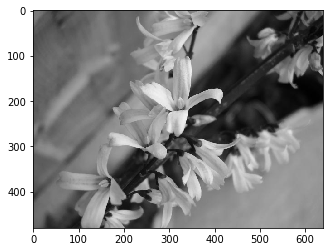

In [55]:
plt.imshow(dst,'gray')